# GPT Model
In this part, I build an LLM model based on the GPT architecture. Specifically the gpt-2 architecture, created by OpenAI. The config is as follows:

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # vocab size
    "context_length": 1024, # sequence length
    "n_layers": 12, # number of layers
    "n_heads": 12, # number of attention heads
    "n_embd": 768, # embedding dimension
    "dropout": 0.1, # dropout rate
    "qkv_bias": False, # bias for qkv if True
}

## Typical GPT model architecture
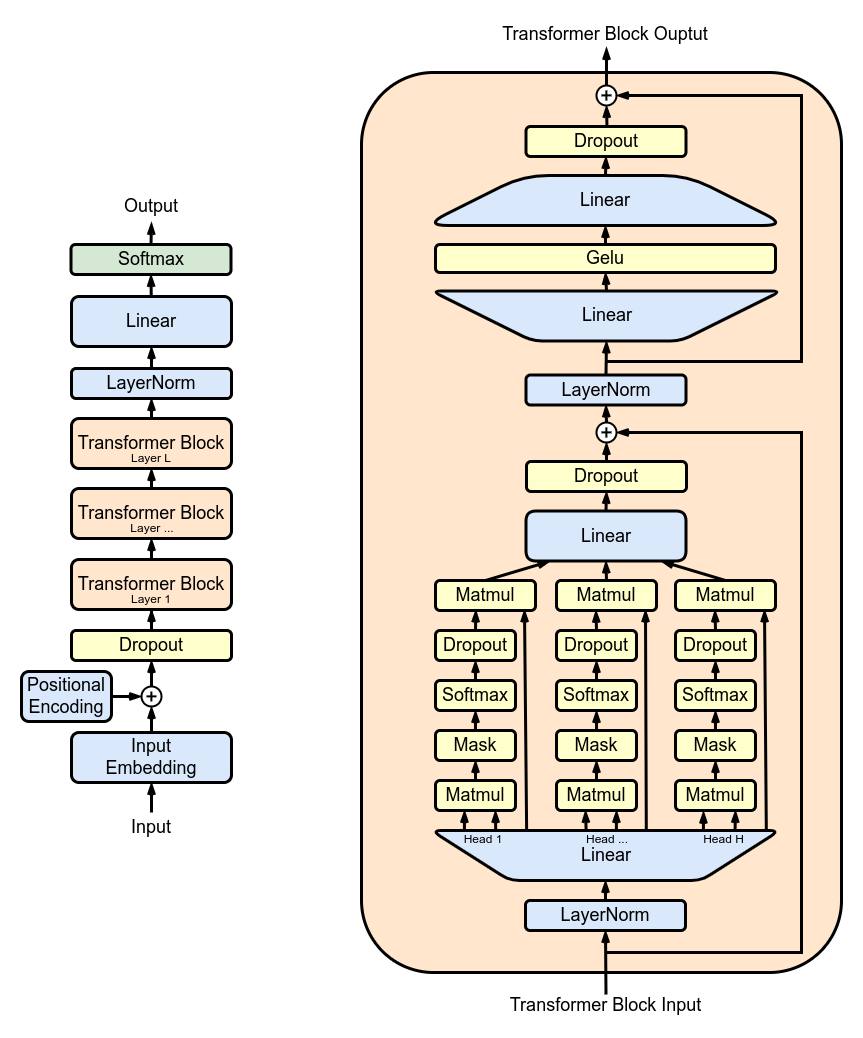

Let's build the model step by step.

## Layer Norm
Layer normalization is a technique used to stabilize the training of deep neural networks. It normalizes the activations of each layer's output to have a mean of zero and a standard deviation of one. This helps in stabilizing the training process and can lead to faster convergence and better performance.

Layer normalization is applied to the output of each layer in a neural network, independently for each sample in the batch. It is different from batch normalization, which normalizes the activations across the batch dimension.

The formula for layer normalization is:

LN(x) = γ * (x - μ) / σ + β

In [2]:
import torch
batch_example = torch.randn(2, 5)
batch_example


tensor([[-2.1686, -0.8187,  1.6192, -2.1955,  0.2163],
        [-0.6474, -0.3137, -1.3762,  0.2784, -0.0429]])

In [3]:
import torch.nn as nn

torch.manual_seed(42)
layer_norm = nn.LayerNorm(5)
layer_norm(batch_example)

tensor([[-1.0286, -0.1024,  1.5703, -1.0470,  0.6077],
        [-0.4005,  0.1881, -1.6858,  1.2324,  0.6658]],
       grad_fn=<NativeLayerNormBackward0>)

In [4]:
class LayerNorm(nn.Module):
    """
    Layer normalization module

    args:
    - emb_dim: the dimension of the embedding
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

layer_norm = LayerNorm(5)
layer_norm(batch_example)


tensor([[-1.0286, -0.1024,  1.5703, -1.0470,  0.6077],
        [-0.4005,  0.1881, -1.6858,  1.2324,  0.6658]], grad_fn=<AddBackward0>)

## GELU
GELU (Gaussian Error Linear Unit) is an activation function used in neural networks. It is designed to provide a smooth transition between the linear and non-linear regions of the activation function, which can help in training deep neural networks. GELU is defined as:

GELU(x) = x * Φ(x)

where Φ(x) is the cumulative distribution function (CDF) of the standard normal distribution.

GELU has been shown to perform well in practice and has been used in various applications, including natural language processing tasks. Let's implement it in PyTorch.

In [5]:
class GELU(nn.Module):
    """
    GELU activation function
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

The advantage of GELU over commonly used ReLU is that it has a smooth transition from the linear to the non-linear region, which can help in training deep neural networks.

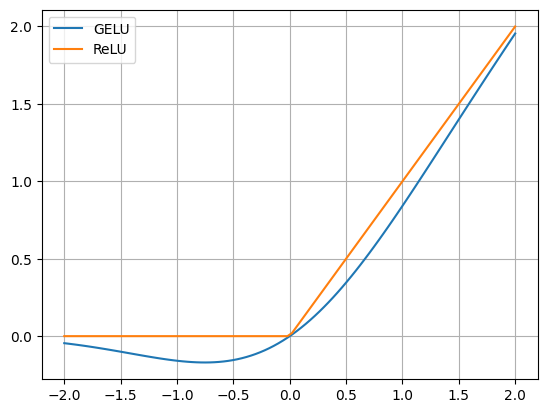

In [6]:
import torch.nn as nn
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-2, 2, 100)

plt.plot(x, gelu(x), label='GELU')
plt.plot(x, relu(x), label='ReLU')
plt.grid(True)
plt.legend()
plt.show()

## Feed-Forward Layer
The feed-forward layer is a crucial component of the GPT model. It is responsible for processing the output of the self-attention mechanism and producing the final output. The feed-forward layer is a simple two-layer neural network with a GELU activation function.

The feed-forward layer is applied to the output of the self-attention mechanism independently for each position in the sequence. It consists of two linear transformations with a GELU activation function in between.

Let's implement the feed-forward layer in PyTorch.


In [7]:
class FeedForward(nn.Module):
    """
    Feed-forward layer
    """
    def __init__(self, cfg):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cfg["n_embd"], 4 * cfg["n_embd"]),
            GELU(),
            nn.Linear(4 * cfg["n_embd"], cfg["n_embd"]))

    def forward(self, x):
        return self.net(x)

print(GPT_CONFIG_124M["n_embd"])

768


In [8]:
torch.manual_seed(42)
ff = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, GPT_CONFIG_124M["n_embd"])
output = ff(x)
print(output.shape)


torch.Size([2, 3, 768])


## Transformer Block
We can now build the transformer block. It is a combination of a self-attention mechanism and a feed-forward layer. The transformer block is applied to the input sequence independently for each position in the sequence. In addition we use the activation function after the feed-forward layer, and introduce short-cut connections around the self-attention and feed-forward layers. Let's build it using the components we have built so far.

In [9]:
import sys
sys.path.append('../')
from attention_mechanism.multi_head_attention import MultiHeadAttention

class TransformerBlock(nn.Module):
    """
    Transformer block
    """
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["n_embd"],
            d_out=cfg["n_embd"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["dropout"])
        self.ln1 = LayerNorm(cfg["n_embd"])
        self.ln2 = LayerNorm(cfg["n_embd"])
        self.ff = FeedForward(cfg)
        self.dropout = nn.Dropout(cfg["dropout"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.ln1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.dropout(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut  # Add the original input back
        return x

torch.manual_seed(42)
block = TransformerBlock(GPT_CONFIG_124M)
x = torch.randn(2, 4, GPT_CONFIG_124M["n_embd"])
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## GPT Model
We can now build the GPT model. The GPT model is a transformer model with a causal language modeling objective. The GPT model is applied to the input sequence independently for each position in the sequence. The GPT model is a sequence-to-sequence model, meaning it takes a sequence of tokens as input and produces a sequence of tokens as output.


In [10]:
class GPT(nn.Module):
    """
    GPT model
    """
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["n_embd"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["n_embd"])
        self.dropout = nn.Dropout(cfg["dropout"])
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.ln_f = LayerNorm(cfg["n_embd"])
        self.head = nn.Linear(cfg["n_embd"], cfg["vocab_size"], bias=False)
    
    def forward(self, x):
        _, seq_len = x.shape
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = tok_emb + pos_emb
        x = self.dropout(x)
        x = self.transformer_blocks(x)
        x = self.ln_f(x)
        return self.head(x)

In [11]:
import tiktoken
tokenizer = tiktoken.encoding_for_model("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [12]:
torch.manual_seed(42)
gpt = GPT(GPT_CONFIG_124M)
output = gpt(batch)
print(output.shape)
print(output)

torch.Size([2, 4, 50257])
tensor([[[-0.2874,  0.7502, -0.0739,  ...,  0.7049,  0.0995,  0.5583],
         [-0.7177,  0.4076,  0.8886,  ..., -0.1226, -1.5020, -0.1120],
         [-0.5273, -0.3509,  0.8918,  ...,  0.6463, -0.6504,  0.2482],
         [-0.2499,  0.4179,  0.2799,  ..., -0.4695, -1.6431,  0.8183]],

        [[-0.2946,  0.7781, -0.1440,  ...,  0.9741,  0.3516,  0.4287],
         [ 0.0721,  0.2304, -0.6400,  ...,  0.1119, -1.4234, -0.0839],
         [ 0.7660, -0.1638,  0.1064,  ...,  0.5393, -1.1459,  0.4974],
         [-0.4581,  0.2273,  0.1957,  ..., -0.2349, -0.5816,  0.8644]]],
       grad_fn=<UnsafeViewBackward0>)


In [13]:
total_params = sum(p.numel() for p in gpt.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 163,000,320


In [14]:
def generate_text_simple(model, input_tensor, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    idx = input_tensor
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [15]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [17]:
gpt.eval() # disable dropout

out = generate_text_simple(
    model=gpt,
    input_tensor=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[15496,    11,   314,   716,  6635, 37226,  8578, 22556, 25143, 38518]])
Output length: 10


In [18]:
decoded = tokenizer.decode(out.squeeze(0).tolist())
print("decoded:", decoded)

decoded: Hello, I am totallySourceFile Buddyy DolHide
